In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [ ]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['dataset.zip']), 'r')
data.extractall()

In [2]:
pip install keras_tuner


   -------------------- ------------------- 1/2 [keras_tuner]
   ---------------------------------------- 2/2 [keras_tuner]

Note: you may need to restart the kernel to use updated packages.


# CNN

In [3]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, RandomFlip, RandomBrightness, RandomContrast, RandomZoom, RandomRotation, Rescaling,
    Conv2D, BatchNormalization, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import backend as k
import keras_tuner as kt
import pandas as pd

In [4]:
seed = 1000
batch_size = 8
img_size = 224

In [5]:
train_ds, val_ds = image_dataset_from_directory(
    directory="./dataset",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=False,
    verbose=True,
)

Found 1265 files belonging to 2 classes.
Using 1012 files for training.
Using 253 files for validation.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
def build_model(hp):
    k.clear_session()
    data_augmentation = Sequential([
        RandomFlip(mode="horizontal", seed=seed),
        RandomBrightness(factor=0.2, seed=seed),
        RandomContrast(factor=0.2, seed=seed),
        RandomRotation(factor=0.2, seed=seed),
        RandomZoom(0.2, seed=seed)
    ])

    hp_filters_conv_1 = hp.Int('filters_conv_1', min_value=8, max_value=32, step=8)
    hp_kernel_size_conv_1 = hp.Int('kernel_size_conv_1', min_value=1, max_value=7, step=1)

    hp_filters_conv_2 = hp.Int('filters_conv_2', min_value=8, max_value=64, step=8)
    hp_kernel_size_conv_2 = hp.Int('kernel_size_conv_2', min_value=1, max_value=7, step=1)

    hp_filters_conv_3 = hp.Int('filters_conv_3', min_value=8, max_value=128, step=8)
    hp_kernel_size_conv_3 = hp.Int('kernel_size_conv_3', min_value=1, max_value=7, step=1)

    hp_units_dense_1 = hp.Int('units_dense_1', min_value=16, max_value=1024, step=16)
    hp_units_dense_2 = hp.Int('units_dense_2', min_value=16, max_value=1024, step=16)

    hp_dropout_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.05)
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.05)

    model = Sequential([
        Input(shape=(img_size, img_size, 3)),
        data_augmentation,
        Rescaling(1./255),
        Conv2D(filters=hp_filters_conv_1, kernel_size=(hp_kernel_size_conv_1, hp_kernel_size_conv_1), activation="relu", kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=hp_filters_conv_2, kernel_size=(hp_kernel_size_conv_2, hp_kernel_size_conv_2), activation="relu", kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=hp_filters_conv_3, kernel_size=(hp_kernel_size_conv_3, hp_kernel_size_conv_3), activation="relu", kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=hp_units_dense_1, activation="relu", kernel_initializer="he_normal"),
        Dropout(hp_dropout_1),
        Dense(units=hp_units_dense_2, activation="relu", kernel_initializer="he_normal"),
        Dropout(hp_dropout_2),
        Dense(units=1, activation="sigmoid")
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[BinaryAccuracy, Precision, Recall])

    return model

In [11]:
tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_binary_accuracy', direction='max'), # Otimizar para a maior acurácia de validação
    max_trials=20, # Número máximo de combinações de hiperparâmetros a serem testadas
    directory='keras_tuner_dir/test_1', # Diretório para salvar os resultados do tuner
    project_name='binary_classification_tuning',
    overwrite=True # Sobrescrever resultados anteriores se o diretório já existir
)

In [12]:
print("\n--- Iniciando a busca de hiperparâmetros com Keras Tuner ---")
tuner.search(train_ds,
             validation_data=val_ds,
             epochs=30, # Você pode usar um número menor de épocas para o tuning para acelerar
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5)])


Trial 20 Complete [00h 06m 34s]
val_binary_accuracy: 0.5494071245193481

Best val_binary_accuracy So Far: 0.8221343755722046
Total elapsed time: 02h 23m 59s


In [13]:
# Obter o melhor modelo e seus hiperparâmetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n--- Melhores hiperparâmetros encontrados: ---")
print(best_hp.values)


--- Melhores hiperparâmetros encontrados: ---
{'filters_conv_1': 32, 'kernel_size_conv_1': 3, 'filters_conv_2': 64, 'kernel_size_conv_2': 2, 'filters_conv_3': 8, 'kernel_size_conv_3': 6, 'units_dense_1': 864, 'units_dense_2': 128, 'dropout_1': 0.25, 'dropout_2': 0.35000000000000003, 'learning_rate': 0.0001}


In [14]:
tuner.results_summary()

Results summary
Results in keras_tuner_dir/test_1\binary_classification_tuning
Showing 10 best trials
Objective(name="val_binary_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
filters_conv_1: 32
kernel_size_conv_1: 3
filters_conv_2: 64
kernel_size_conv_2: 2
filters_conv_3: 8
kernel_size_conv_3: 6
units_dense_1: 864
units_dense_2: 128
dropout_1: 0.25
dropout_2: 0.35000000000000003
learning_rate: 0.0001
Score: 0.8221343755722046

Trial 17 summary
Hyperparameters:
filters_conv_1: 24
kernel_size_conv_1: 2
filters_conv_2: 64
kernel_size_conv_2: 2
filters_conv_3: 104
kernel_size_conv_3: 3
units_dense_1: 832
units_dense_2: 448
dropout_1: 0.15000000000000002
dropout_2: 0.25
learning_rate: 0.0001
Score: 0.8221343755722046

Trial 10 summary
Hyperparameters:
filters_conv_1: 8
kernel_size_conv_1: 2
filters_conv_2: 40
kernel_size_conv_2: 2
filters_conv_3: 80
kernel_size_conv_3: 5
units_dense_1: 1008
units_dense_2: 768
dropout_1: 0.35000000000000003
dropout_2: 0.25
learning_rate: 0.0

# Gráficos bacanas

In [15]:
num_trials = tuner.oracle.max_trials or len(tuner.oracle.trials)
trials = tuner.oracle.get_best_trials(num_trials=num_trials)

data = []
for trial in trials:
    trial_data = {
        'trial_id': trial.trial_id,
        'score': trial.score,
        'status': trial.status
    }

    # Adiciona os hiperparâmetros
    for hp_name, hp_value in trial.hyperparameters.values.items():
        trial_data[hp_name] = hp_value

    # Acessa as métricas diretamente do dicionário `trial.metrics`
    if trial.metrics:
        # Pega as métricas do último passo (última época)
        for metric_name, metric_values in trial.metrics.metrics.items():
            if metric_values.get_history():
                last_value = metric_values.get_last_value()
                if last_value is not None:
                    trial_data[f'final_{metric_name}'] = last_value

    data.append(trial_data)

df_trials = pd.DataFrame(data)
print(df_trials.head())

  trial_id     score     status  filters_conv_1  kernel_size_conv_1  \
0       07  0.822134  COMPLETED              32                   3   
1       17  0.822134  COMPLETED              24                   2   
2       10  0.814229  COMPLETED               8                   2   
3       06  0.806324  COMPLETED               8                   5   
4       02  0.798419  COMPLETED               8                   6   

   filters_conv_2  kernel_size_conv_2  filters_conv_3  kernel_size_conv_3  \
0              64                   2               8                   6   
1              64                   2             104                   3   
2              40                   2              80                   5   
3              64                   7              96                   3   
4              64                   4             128                   4   

   units_dense_1  ...  dropout_2  learning_rate  final_binary_accuracy  \
0            864  ...       0.35    

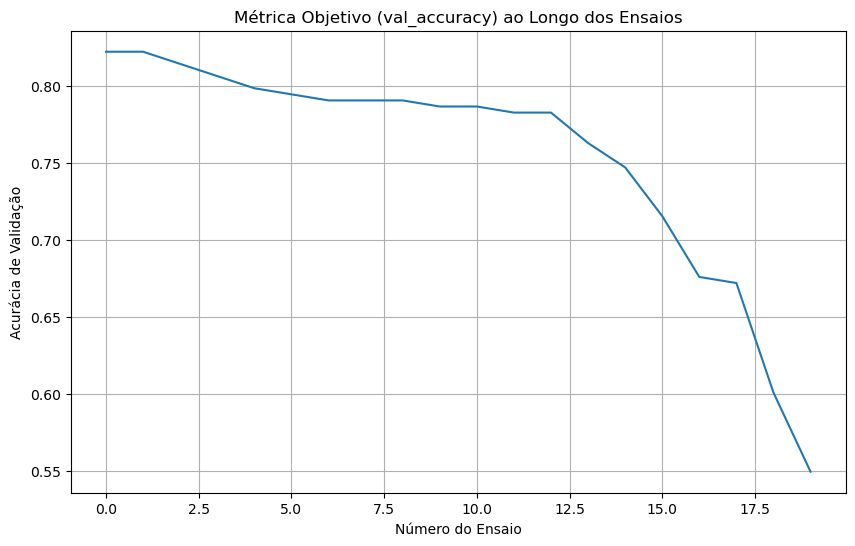

In [16]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_trials.index, y='score', data=df_trials)
plt.title('Métrica Objetivo (val_accuracy) ao Longo dos Ensaios')
plt.xlabel('Número do Ensaio')
plt.ylabel('Acurácia de Validação')
plt.grid(True)
plt.show()

C:\Users\henri\AppData\Local\Temp\ipykernel_6296\3097500041.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_trials, x='trial_id', y='score', palette='mako')


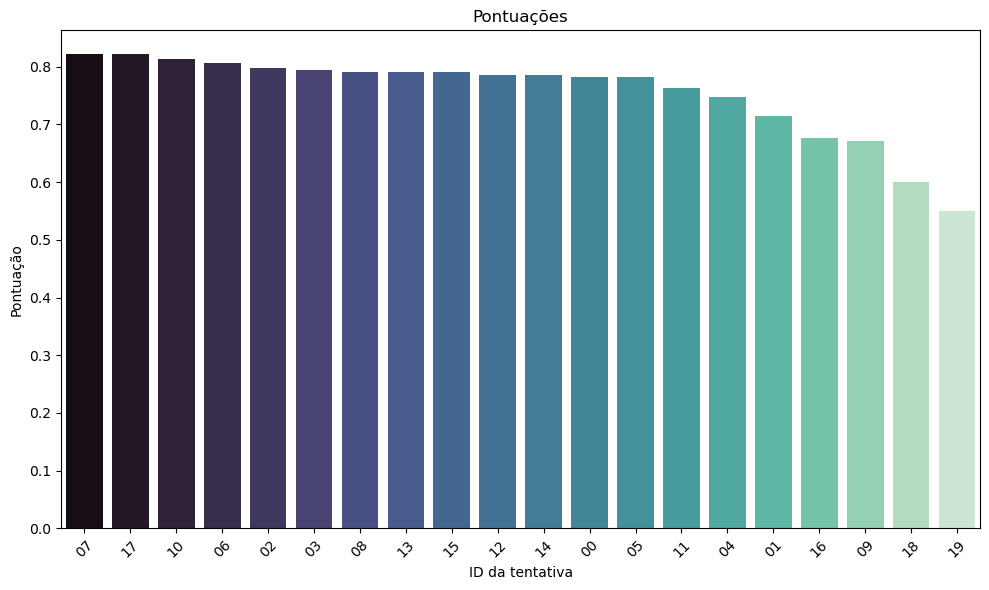

In [17]:
top_trials = df_trials.sort_values(by='score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_trials, x='trial_id', y='score', palette='mako')
plt.title('Pontuações')
plt.xlabel('ID da tentativa')
plt.ylabel('Pontuação')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

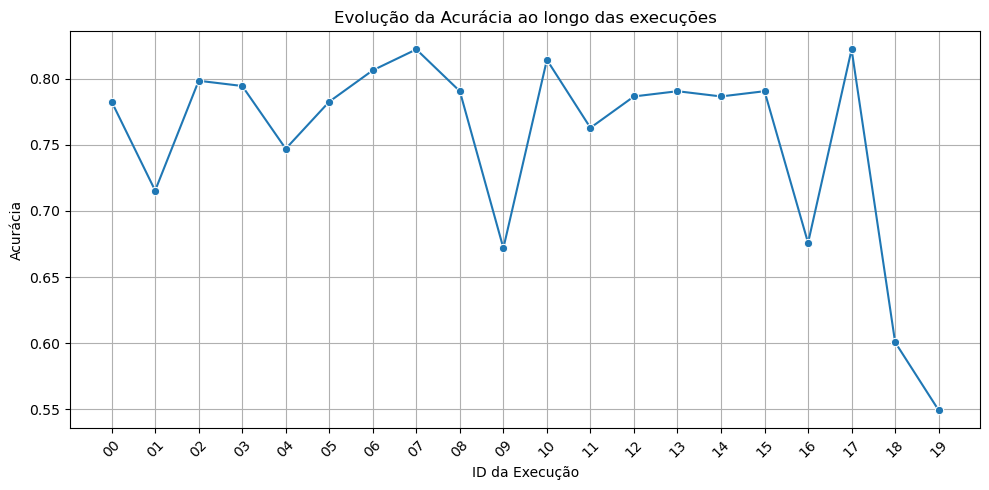

In [18]:
df_trials_sorted = df_trials.sort_values(by='trial_id')

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_trials_sorted, x='trial_id', y='score', marker='o')
plt.title('Evolução da Acurácia ao longo das execuções')
plt.xlabel('ID da Execução')
plt.ylabel('Acurácia')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()